In [2]:
%load_ext autoreload
%load_ext nb_black
%autoreload 2

<IPython.core.display.Javascript object>

In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from toai.imports import *
from tensorflow.keras.preprocessing.sequence import pad_sequences

/home/martynas/ml/.venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


<IPython.core.display.Javascript object>

In [4]:
tf.debugging.set_log_device_placement(False)
gpus = tf.config.experimental.list_physical_devices("GPU")
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            print(gpu)
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices("GPU")
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


<IPython.core.display.Javascript object>

In [5]:
DATA_DIR = Path("data")
TEMP_DIR = Path("temp")
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

<IPython.core.display.Javascript object>

In [6]:
df = pd.read_csv(DATA_DIR / "pmsm_temperature_data.csv")

<IPython.core.display.Javascript object>

In [7]:
df.head()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
0,-0.752143,-1.118446,0.327935,-1.297858,-1.222428,-0.250182,1.029572,-0.245860,-2.522071,-1.831422,-2.066143,-2.018033,4
1,-0.771263,-1.117021,0.329665,-1.297686,-1.222429,-0.249133,1.029509,-0.245832,-2.522418,-1.830969,-2.064859,-2.017631,4
2,-0.782892,-1.116681,0.332771,-1.301822,-1.222428,-0.249431,1.029448,-0.245818,-2.522673,-1.830400,-2.064073,-2.017343,4
3,-0.780935,-1.116764,0.333700,-1.301852,-1.222430,-0.248636,1.032845,-0.246955,-2.521639,-1.830333,-2.063137,-2.017632,4
4,-0.774043,-1.116775,0.335206,-1.303118,-1.222429,-0.248701,1.031807,-0.246610,-2.521900,-1.830498,-2.062795,-2.018145,4


<IPython.core.display.Javascript object>

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 998070 entries, 0 to 998069
Data columns (total 13 columns):
ambient           998070 non-null float64
coolant           998070 non-null float64
u_d               998070 non-null float64
u_q               998070 non-null float64
motor_speed       998070 non-null float64
torque            998070 non-null float64
i_d               998070 non-null float64
i_q               998070 non-null float64
pm                998070 non-null float64
stator_yoke       998070 non-null float64
stator_tooth      998070 non-null float64
stator_winding    998070 non-null float64
profile_id        998070 non-null int64
dtypes: float64(12), int64(1)
memory usage: 99.0 MB


<IPython.core.display.Javascript object>

In [9]:
def show_profiles():
    sns.catplot(
        x="profile_id",
        kind="count",
        data=df,
        height=5,
        aspect=16 / 5,
        palette=sns.color_palette(["blue"]),
    )

<IPython.core.display.Javascript object>

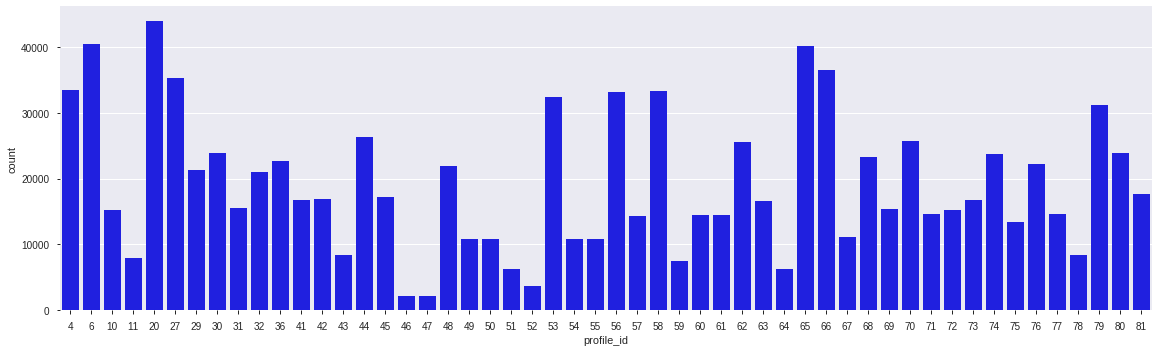

<IPython.core.display.Javascript object>

In [10]:
show_profiles()

In [11]:
df["profile_id"].value_counts(ascending=True)[:10]

47     2175
46     2179
52     3725
64     6249
51     6260
59     7474
11     7886
43     8442
78     8444
54    10806
Name: profile_id, dtype: int64

<IPython.core.display.Javascript object>

In [12]:
to_drop = list(df["profile_id"].value_counts(ascending=True)[:10].index)
to_drop

[47, 46, 52, 64, 51, 59, 11, 43, 78, 54]

<IPython.core.display.Javascript object>

In [13]:
df = df.drop(df[df["profile_id"].isin(to_drop)].index)

<IPython.core.display.Javascript object>

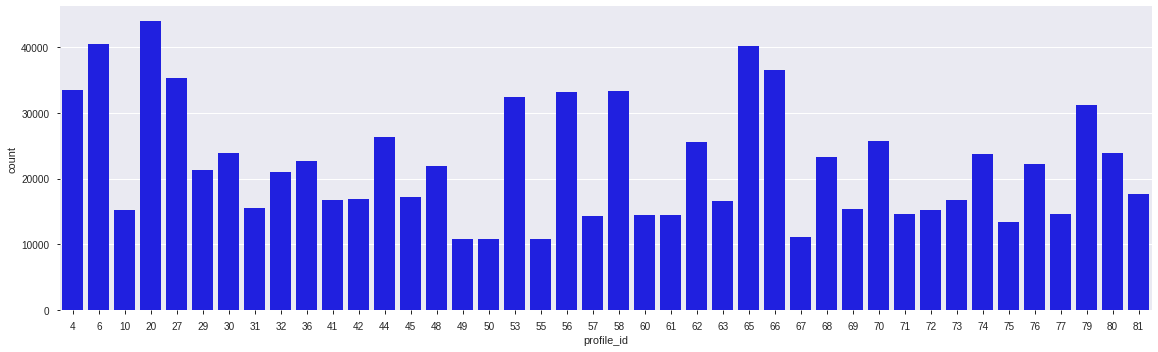

<IPython.core.display.Javascript object>

In [14]:
show_profiles()

In [15]:
df.describe()

,ambient,coolant,u_d,u_q,motor_speed,torque,i_d,i_q,pm,stator_yoke,stator_tooth,stator_winding,profile_id
count,934430.000000,934430.000000,934430.000000,934430.000000,934430.000000,934430.000000,934430.000000,934430.000000,934430.000000,934430.000000,934430.000000,934430.000000,934430.000000
mean,-0.007277,-0.001941,0.001642,-0.015378,-0.011494,-0.000141,0.012897,0.000231,0.000660,-0.010014,-0.013284,-0.015613,50.710978
std,1.009987,1.005628,0.990610,1.007717,1.009351,0.988078,1.002403,0.987562,1.001620,1.001384,1.002585,1.003876,22.313319
min,-8.573954,-1.429349,-1.655373,-1.861463,-1.239020,-3.345953,-3.245874,-3.341639,-2.631991,-1.834688,-2.066143,-2.019973,4.000000
25%,-0.596192,-1.039760,-0.823983,-0.973555,-0.956653,-0.264893,-0.753971,-0.254450,-0.667380,-0.760559,-0.762025,-0.726357,32.000000
50%,0.262840,-0.180940,0.267866,-0.108275,-0.140247,-0.187768,0.239510,-0.198750,0.100089,-0.057686,-0.002990,-0.002648,56.000000
75%,0.687046,0.702431,0.356749,0.845277,0.860147,0.531836,1.013983,0.486929,0.691804,0.698009,0.773361,0.719672,69.000000
max,2.967117,2.297432,2.274734,1.793498,2.024164,3.016971,1.060937,2.914185,2.917456,2.449158,2.326668,2.653781,81.000000


<IPython.core.display.Javascript object>

In [16]:
def show_current_and_voltages(df, profile):
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 4))
    plt.sca(axes[0])
    series = df[df.profile_id == profile][["u_d", "u_q"]].values
    plt.plot(series[:, 0], label="u_d")
    plt.plot(series[:, 1], label="u_q")
    plt.legend(loc="upper left")
    plt.sca(axes[1])
    series = df[df.profile_id == profile][["i_d", "i_q"]].values
    plt.plot(series[:, 0], label="i_d")
    plt.plot(series[:, 1], label="i_q")
    plt.legend(loc="upper left")

<IPython.core.display.Javascript object>

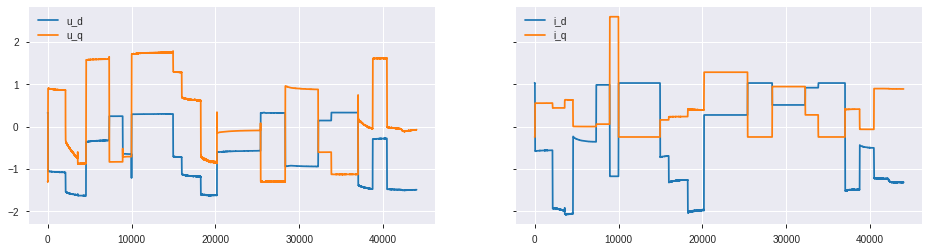

<IPython.core.display.Javascript object>

In [17]:
show_current_and_voltages(df, 20)

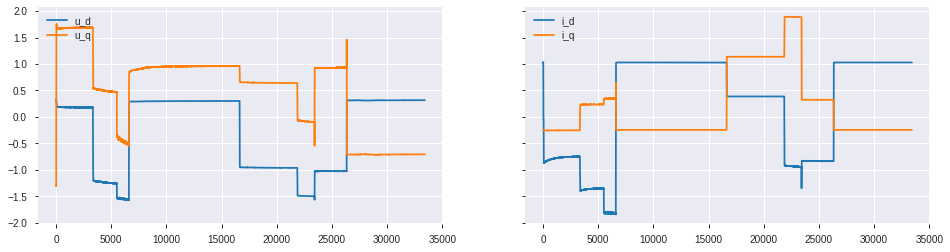

<IPython.core.display.Javascript object>

In [18]:
show_current_and_voltages(df, 4)

In [19]:
df["voltage"] = np.sqrt(df["u_d"] ** 2 + df["u_q"] ** 2)
df["current"] = np.sqrt(df["i_d"] ** 2 + df["i_q"] ** 2)
df.drop(["u_d", "u_q", "i_d", "i_q"], inplace=True, axis=1)

<IPython.core.display.Javascript object>

In [20]:
df.head()

,ambient,coolant,motor_speed,torque,pm,stator_yoke,stator_tooth,stator_winding,profile_id,voltage,current
0,-0.752143,-1.118446,-1.222428,-0.250182,-2.522071,-1.831422,-2.066143,-2.018033,4,1.338647,1.058521
1,-0.771263,-1.117021,-1.222429,-0.249133,-2.522418,-1.830969,-2.064859,-2.017631,4,1.338906,1.058453
2,-0.782892,-1.116681,-1.222428,-0.249431,-2.522673,-1.830400,-2.064073,-2.017343,4,1.343680,1.058390
3,-0.780935,-1.116764,-1.222430,-0.248636,-2.521639,-1.830333,-2.063137,-2.017632,4,1.343940,1.061958
4,-0.774043,-1.116775,-1.222429,-0.248701,-2.521900,-1.830498,-2.062795,-2.018145,4,1.345541,1.060869


<IPython.core.display.Javascript object>

In [21]:
def show_current_and_voltages_merged(df, profiles):
    fig, axes = plt.subplots(nrows=1, ncols=len(profiles), sharey=True, figsize=(16, 4))

    for idx, profile in enumerate(profiles):
        plt.sca(axes[idx])
        series = df[df.profile_id == profile][["voltage", "current"]].values
        plt.plot(series[:, 0], label="voltage")
        plt.plot(series[:, 1], label="current")
        plt.legend(loc="upper left")

<IPython.core.display.Javascript object>

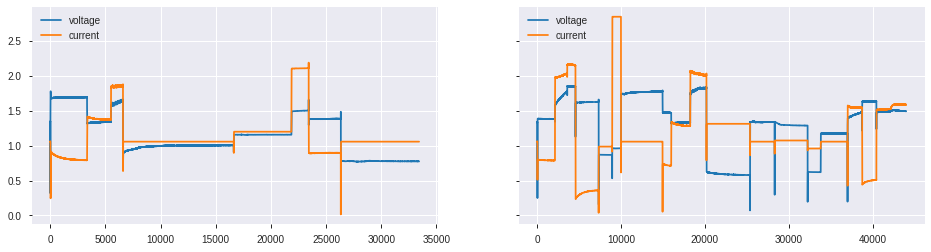

<IPython.core.display.Javascript object>

In [22]:
show_current_and_voltages_merged(df, [4, 20])

In [23]:
def show_temp_speed(df, profile_id):
    series = df[df.profile_id == profile_id][["pm", "stator_yoke"]].values
    plt.plot(series)

<IPython.core.display.Javascript object>

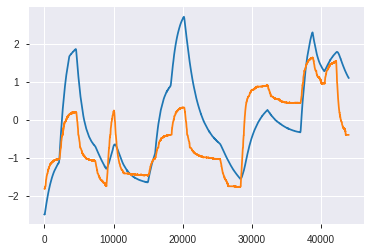

<IPython.core.display.Javascript object>

In [24]:
show_temp_speed(df, 20)

In [25]:
data = []
targets = []
max_session_len = 0
for profile in df["profile_id"].unique():
    d = df[df["profile_id"] == profile].drop("profile_id", axis=1)
    max_session_len = d.shape[0] if max_session_len < d.shape[0] else max_session_len
    profile_data = df[df["profile_id"] == profile]
    data.append(profile_data.drop(["profile_id", "pm"], axis=1).values)
    targets.append(profile_data["pm"].values)
data = np.asarray(data)
targets = np.asarray(targets)

<IPython.core.display.Javascript object>

In [26]:
data_padded = pad_sequences(data, maxlen=max_session_len, dtype="float64", value=0.0000)
tagets_padded = pad_sequences(
    targets, maxlen=max_session_len, dtype="float64", value=0.0000
)

<IPython.core.display.Javascript object>

Verify that padding was performed successfuly

In [27]:
data.shape, data[0].shape, data_padded.shape, tagets_padded.shape

((42,), (33423, 9), (42, 43970, 9), (42, 43970))

<IPython.core.display.Javascript object>

In [28]:
data[0][-1]

array([ 0.32668257, -1.0830811 , -0.9518845 , -0.25607744, -1.7473158 ,
       -1.9857602 , -1.9712014 ,  0.77551189,  1.05807924])

<IPython.core.display.Javascript object>

In [29]:
data_padded[0][-1]

array([ 0.32668257, -1.0830811 , -0.9518845 , -0.25607744, -1.7473158 ,
       -1.9857602 , -1.9712014 ,  0.77551189,  1.05807924])

<IPython.core.display.Javascript object>

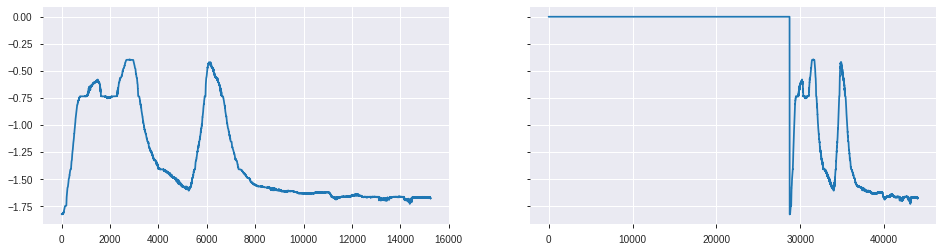

<IPython.core.display.Javascript object>

In [30]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(16, 4))
plt.sca(axes[0])
series = data[2][:, 4]
plt.plot(series)
plt.sca(axes[1])
series = data_padded[2, :, 4]
plt.plot(series)

In [31]:
data_padded.shape, tagets_padded.shape

((42, 43970, 9), (42, 43970))

<IPython.core.display.Javascript object>

In [49]:
train_data, test_data, train_label, test_label = train_test_split(
    data_padded, tagets_padded, test_size=0.2, shuffle=False
)
val_data, test_data, val_label, test_label = train_test_split(
    test_data, test_label, test_size=0.5, shuffle=False
)

<IPython.core.display.Javascript object>

In [51]:
[
    data.shape
    for data in [train_data, test_data, val_data, train_label, val_label, test_label]
]

[(33, 43970, 9),
 (5, 43970, 9),
 (4, 43970, 9),
 (33, 43970),
 (4, 43970),
 (5, 43970)]

<IPython.core.display.Javascript object>

In [52]:
model = keras.models.Sequential(
    [
        keras.layers.LSTM(128, return_sequences=True, input_shape=[None, 9]),
        keras.layers.LSTM(50, return_sequences=True),
        keras.layers.Conv1D(1, kernel_size=1),
    ]
)

<IPython.core.display.Javascript object>

In [53]:
model.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=1e-3))

<IPython.core.display.Javascript object>

In [54]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 128)         70656     
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 50)          35800     
_________________________________________________________________
conv1d (Conv1D)              (None, None, 1)           51        
Total params: 106,507
Trainable params: 106,507
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [55]:
model.fit(
    train_data,
    train_label,
    validation_data=(val_data, val_label),
    epochs=10,
    batch_size=1,
    verbose=1,
)

Train on 33 samples, validate on 4 samples
Epoch 1/10
33/33 [==============================] - 54s 2s/sample - loss: 0.2426 - val_loss: 0.1591
Epoch 2/10
33/33 [==============================] - 51s 2s/sample - loss: 0.1807 - val_loss: 0.1174
Epoch 3/10
33/33 [==============================] - 52s 2s/sample - loss: 0.1599 - val_loss: 0.1397
Epoch 4/10
33/33 [==============================] - 52s 2s/sample - loss: 0.1513 - val_loss: 0.1275
Epoch 5/10
33/33 [==============================] - 52s 2s/sample - loss: 0.1386 - val_loss: 0.1481
Epoch 6/10
33/33 [==============================] - 52s 2s/sample - loss: 0.1536 - val_loss: 0.1155
Epoch 7/10
33/33 [==============================] - 52s 2s/sample - loss: 0.1393 - val_loss: 0.1091
Epoch 8/10
33/33 [==============================] - 52s 2s/sample - loss: 0.1299 - val_loss: 0.1253
Epoch 9/10
33/33 [==============================] - 52s 2s/sample - loss: 0.1226 - val_loss: 0.0994
Epoch 10/10
33/33 [==============================] - 52s 

<IPython.core.display.Javascript object>

In [56]:
model.evaluate(test_data, test_label, verbose=3)

0.13662707805633545

<IPython.core.display.Javascript object>

In [57]:
model_gru = keras.models.Sequential(
    [
        keras.layers.GRU(128, return_sequences=True, input_shape=[None, 9]),
        keras.layers.GRU(50, return_sequences=True),
        keras.layers.Conv1D(1, kernel_size=1),
    ]
)

<IPython.core.display.Javascript object>

In [58]:
model_gru.compile(loss=keras.losses.mse, optimizer=keras.optimizers.Adam(lr=1e-3))

<IPython.core.display.Javascript object>

In [59]:
model_gru.fit(
    train_data,
    train_label,
    validation_data=(val_data, val_label),
    epochs=10,
    batch_size=1,
    verbose=1,
)

Train on 33 samples, validate on 4 samples
Epoch 1/10
33/33 [==============================] - 53s 2s/sample - loss: 0.2763 - val_loss: 0.2211
Epoch 2/10
33/33 [==============================] - 51s 2s/sample - loss: 0.2089 - val_loss: 0.1738
Epoch 3/10
33/33 [==============================] - 52s 2s/sample - loss: 0.1933 - val_loss: 0.1187
Epoch 4/10
33/33 [==============================] - 52s 2s/sample - loss: 0.1742 - val_loss: 0.0992
Epoch 5/10
33/33 [==============================] - 52s 2s/sample - loss: 0.1736 - val_loss: 0.0958
Epoch 6/10
33/33 [==============================] - 52s 2s/sample - loss: 0.1374 - val_loss: 0.1053
Epoch 7/10
33/33 [==============================] - 52s 2s/sample - loss: 0.1292 - val_loss: 0.0895
Epoch 8/10
33/33 [==============================] - 52s 2s/sample - loss: 0.1264 - val_loss: 0.1072
Epoch 9/10
33/33 [==============================] - 52s 2s/sample - loss: 0.1393 - val_loss: 0.0972
Epoch 10/10
33/33 [==============================] - 52s 

<IPython.core.display.Javascript object>

In [60]:
model_gru.evaluate(test_data, test_label, verbose=3)

0.10955296456813812

<IPython.core.display.Javascript object>